## Imports

In [13]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Imports
import numpy as np
import tensorflow as tf
import keras
print("Reg Train TF version: ", tf.__version__)
print("Reg Train Keras version: ", keras.__version__)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
import cv2 as cv
import math
import os
import time
import pickle

import zipfile
from imageio import imread
# from skimage.io import imread
from skimage.transform import resize
import pprint


import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from utils import preprocess_data, next_batch, calculate_accuracy
from model import Model

print(tf.config.list_physical_devices('GPU'))

Reg Train TF version:  2.6.0
Reg Train Keras version:  2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Test GPU

In [17]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

gpus = tf.config.list_physical_devices('GPU')
if gpus:  
  try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
    
#     # Restrict TensorFlow to only use the first GPU
#     tf.config.set_visible_devices(gpus[0], 'GPU')
    
    # Create 2 virtual GPUs with 1GB memory each
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
         tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices and Memory growth must be set before GPUs have been initialized
    print(e)
    
# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)



Num GPUs Available:  1
Virtual devices cannot be modified after being initialized
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


NameError: name 'config' is not defined

## Constants and Settings

In [2]:


# Settings/parameters to be used later

# Constants
IMG_SIZE = 32  # square image of size IMG_SIZE x IMG_SIZE
GRAYSCALE = False  # convert image to grayscale?
NUM_CHANNELS = 1 if GRAYSCALE else 3
NUM_CLASSES = 43

# Model parameters
LR = 1e-4  # learning rate
KEEP_PROB = 0.5  # dropout keep probability
RATE = 1 - KEEP_PROB
# OPT = tf.train.GradientDescentOptimizer(learning_rate=LR)  # choose which optimizer to use
OPT = tf.optimizers.SGD(learning_rate=LR, momentum = 0, nesterov = False, name='SGD')

# Training process
RESTORE = False  # restore previous model, don't train?
RESUME = False  # resume training from previously trained model?

NUM_EPOCH = 200
coef = 0.00005

BATCH_SIZE = 128  # batch size for training (relatively small)
BATCH_SIZE_INF = 2048  # batch size for running inference, e.g. calculating accuracy
VALIDATION_SIZE = 0.2  # fraction of total training set to use as validation set
SAVE_MODEL = True  # save trained model to disk?
MODEL_SAVE_PATH = './model.ckpt'  # where to save trained model

# Import Dataset

In [3]:
import urllib.request
import os.path
if not os.path.exists("GTSRB_Final_Training_Images.zip"):
    # Get file from URL
    url = ""
    filename = "./GTSRB_Final_Training_Images.zip"
    urllib.request.urlretrieve(url, filename)
    

In [4]:
TEST_SIZE = 0.2        # fraction of total training set to use as test set
VALIDATION_SIZE = 0.2  # fraction of remaining training set to use as validation set

X, Xt, y, yt = list(), list(), list(), list()

archive = zipfile.ZipFile('./GTSRB_Final_Training_Images.zip', 'r')

file_paths = [file for file in archive.namelist() 
              if '.ppm' in file]

for filename in file_paths:
    with archive.open(filename) as img_file:

        img = imread(img_file.read())
        img = resize(img,
                     output_shape=(IMG_SIZE, IMG_SIZE),
                     mode='reflect',
                     anti_aliasing=True
                    )
        img_class = int(filename.split('/')[-2])
        

#     img = imread(archive.open(filename))
#     img = resize(img,
#                  output_shape=(IMG_SIZE, IMG_SIZE),
#                  mode='reflect',
#                  anti_aliasing=True
#                 )
#     img_class = int(filename.split('/')[-2])

    if (hash(filename) % 1000) / 1000 > TEST_SIZE:
        X.append(img)
        y.append(img_class)
    else:
        Xt.append(img)
        yt.append(img_class)
archive.close()
    
# # Load pickled data
# with open('train_aug.p', mode='rb') as f:
#     train = pickle.load(f)

# X_train, y_train = train['features'], train['labels']
# X_train, y_train = preprocess_data(X_train, y_train)

# with open('test.p', mode='rb') as f:
#     test = pickle.load(f)
# X_test, y_test = test['features'], test['labels']
# X_test, y_test = preprocess_data(X_test, y_test)






In [8]:

VALIDATION_SIZE = 0.95  # fraction of remaining training set to use as validation set

#Train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(np.asarray(X), np.asarray(y), test_size=VALIDATION_SIZE)


No classes:43


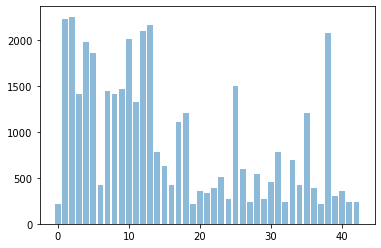

In [9]:
test_ratio = len(Xt) / len(file_paths)
# print("Train size: {} test size: {} ({:0.3f})").format(
#     len(X), 
#     len(Xt),
#     test_ratio)

classes, dist = np.unique(y+yt, return_counts = True)
NUM_CLASSES = len(classes)
print("No classes:{}".format(NUM_CLASSES))

plt.bar(classes, dist, align = 'center', alpha = 0.5)
plt.show()

(1572, 32, 32, 3)
(29884, 32, 32, 3)
(1572,)
(29884,)


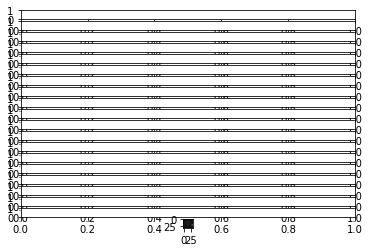

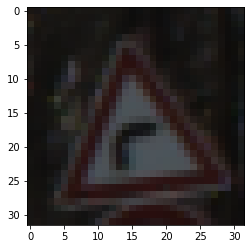

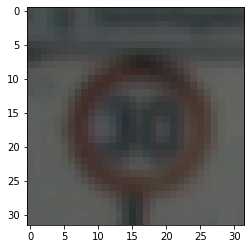

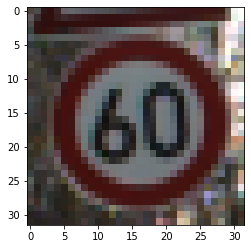

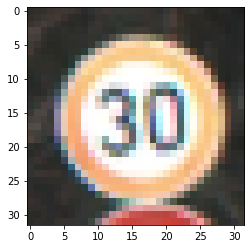

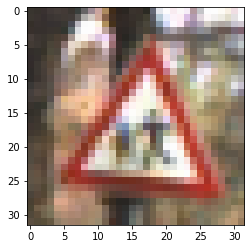

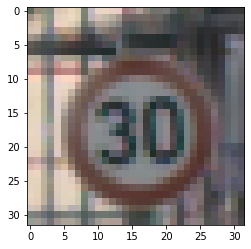

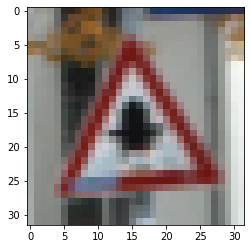

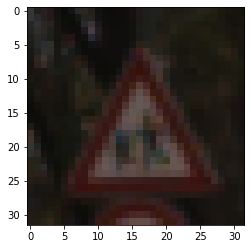

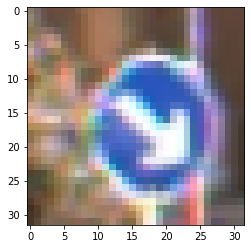

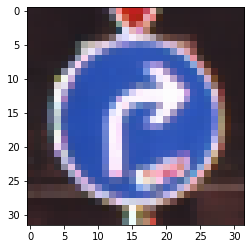

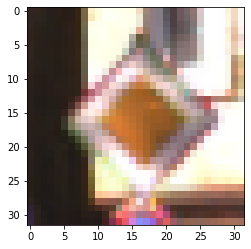

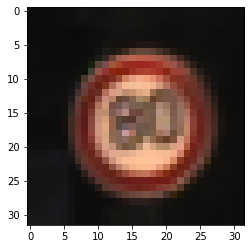

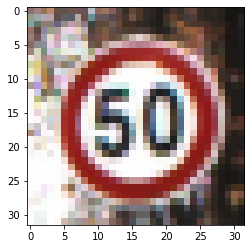

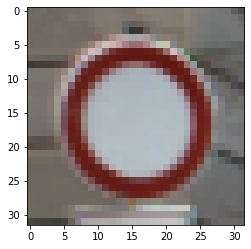

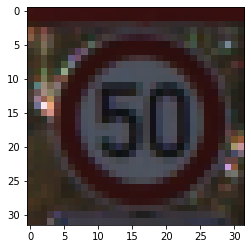

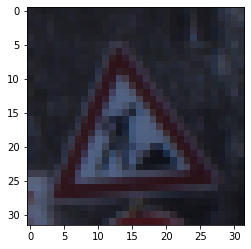

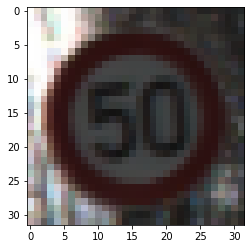

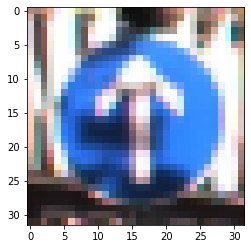

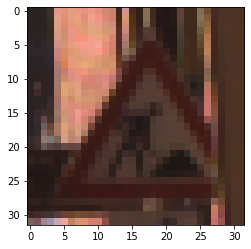

In [10]:

print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

imgs = X_valid
f, imgplot = plt.subplots(20)

for i in range(20):
    img = imgs[i]
    imgplot[i] = plt.imshow(img)
    plt.show()
    

### Model

In [12]:

from model import Model

# Model init and call
model = Model()
model(X_train)

x, y, logits, predictions, accuracy = model.x, model.y, model.logits, model.predictions, model.accuracy
rate = model.rate
loss = model.loss

global_step = tf.train.get_or_create_global_step()

grad_loss = coef * tf.reduce_sum(tf.nn.l2_loss(model.cw_grad))

total_loss = model.loss + grad_loss

# OPT = tf.train.GradientDescentOptimizer(learning_rate=LR) 
OPT = tf.optimizers.SGD(learning_rate=LR, momentum = 0, nesterov = False, name='SGD')

optimizer = OPT.minimize(total_loss, global_step=global_step)


sess = tf.Session()
if True:

	saver = tf.train.Saver()
	filename = tf.train.latest_checkpoint("./begi-robust-model/")
	print("Latest training checkpoint is ", filename)
	if filename != None:
		saver.restore(sess, filename)
	else:
		sess.run(tf.global_variables_initializer())

	last_time = time.time()
	train_start_time = time.time()
	accuracy_history = []

	for epoch in range(NUM_EPOCH):
		# Instantiate generator for training data
		train_gen = next_batch(X_train, y_train, BATCH_SIZE, True)

		# How many batches to run per epoch
		num_batches_train = math.ceil(X_train.shape[0] / BATCH_SIZE)

		# Run training on each batch
		for _ in range(num_batches_train):
			# Obtain the training data and labels from generator
			images, labels = next(train_gen)

			# Perform gradient update (i.e. training step) on current batch
			sess.run(optimizer, feed_dict={x: images, y: labels, rate: RATE})
		# Calculate training and validation accuracy across the *entire* train/validation set
		# If train/validation size % batch size != 0
		# then we must calculate weighted average of the accuracy of the final (partial) batch,
		# w.r.t. the rest of the full batches

		# Training set
		train_gen = next_batch(X_train, y_train, BATCH_SIZE_INF, True)
		train_size = X_train.shape[0]
		train_acc = calculate_accuracy(train_gen, train_size, BATCH_SIZE_INF, accuracy, x, y, rate, sess)

		# Validation set
		valid_gen = next_batch(X_valid, y_valid, BATCH_SIZE_INF, True)
		valid_size = X_valid.shape[0]
		valid_acc = calculate_accuracy(valid_gen, valid_size, BATCH_SIZE_INF, accuracy, x, y, rate, sess)
        

		test_gen = next_batch(X_test, y_test, BATCH_SIZE_INF, False)
		test_size = X_test.shape[0]
		test_acc = calculate_accuracy(test_gen, test_size, BATCH_SIZE_INF, accuracy, x, y, rate, sess)


		# Record and report train/validation/test accuracies for this epoch
		accuracy_history.append((train_acc, valid_acc))

		print('Epoch %d -- Train acc.: %.4f, Validation acc.: %.4f, Test acc.: %.4f, Elapsed time: %.2f sec' %\
		    (epoch+1, train_acc, valid_acc, test_acc, time.time() - last_time))
		last_time = time.time()

	total_time = time.time() - train_start_time
	print('Total elapsed time: %.2f sec (%.2f min)' % (total_time, total_time/60))

	# After training is complete, evaluate accuracy on test set
	print('Calculating test accuracy...')
	test_gen = next_batch(X_test, y_test, BATCH_SIZE_INF, False)
	test_size = X_test.shape[0]
	test_acc = calculate_accuracy(test_gen, test_size, BATCH_SIZE_INF, accuracy, x, y, rate, sess)
	print('Test acc.: %.4f' % (test_acc,))

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'lower'

In [ ]:
if SAVE_MODEL:
#     # Also save accuracy history
#     print('Accuracy history saved at accuracy_history.p')
#     with open('accuracy_history.p', 'wb') as f:
#         pickle.dump(accuracy_history, f)
    saver.save(sess, os.path.join("./begi-robust-model", 'checkpoint'), global_step=global_step)
    print('Model Saved !!!')


In [ ]:
train_gen = next_batch(X_train, y_train, BATCH_SIZE, True)
images, labels = next(train_gen)
gloss = sess.run(model.grad_loss, feed_dict={x: images, y: labels, rate: RATE})

print(gloss)

In [ ]:
sess.close()

In [ ]:
sess = tf.Session()
saver = tf.train.Saver()
filename = tf.train.latest_checkpoint("./natural_model/")
print("Latest training checkpoint is ", filename)
if filename != None:
    saver.restore(sess, filename)

In [ ]:
train_gen = next_batch(X_train, y_train, BATCH_SIZE, True)
images, labels = next(train_gen)
gloss = sess.run(model.grad_loss, feed_dict={x: images, y: labels, rate: RATE})

print(gloss)